In [1]:
from IPython.display import display
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rcParams
from scipy.stats import pearsonr, fisher_exact
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys
from sklearn.metrics import roc_auc_score

from misc import rename_factors #, rename_Y, make_annot, convert_partial_year, rename_blood, rename_pathways, get_phenotype_contrasts
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
ALPHA = 0.8

FDR = [0.05]
TRANSPOSE_ENR_TABLE = True
ENR_FIG_WIDTH, ENR_CELL_HEIGHT = (3, 0.15) if TRANSPOSE_ENR_TABLE else (10, 0.1)
PVAL_ASTERISKS = [0.05, 0.01, 0.001]

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure7')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'

# Machine learning

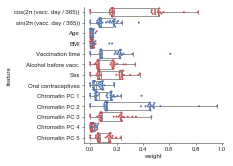

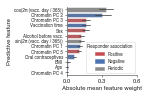

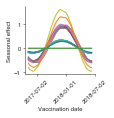

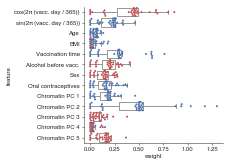

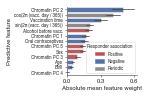

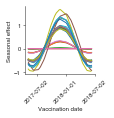

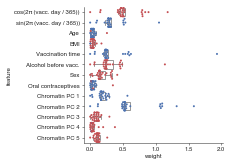

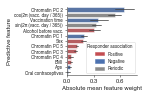

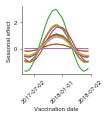

In [3]:
vacc_dates = misc.get_sample_annot()
vacc_dates = vacc_dates.loc[(vacc_dates['SAMPLE:VISIT'] == 'V1') & (vacc_dates['SAMPLE:TISSUE'] == 'PBMC')].set_index('SAMPLE:DONOR')['DONOR:IC_DATE_REAL'].sort_values()
assert vacc_dates.index.is_unique
X_df = pd.read_csv(os.path.join(misc.ML_RESULTS_ROOT, 'X_df.csv.gz'), index_col=0)

for FC_thr in [1.6, 1.7, 1.8]:
    data = np.load(os.path.join(misc.ML_RESULTS_ROOT, 'ATAC_SEASON_DONOR_innate_FC{}.predictions.npz'.format(FC_thr)), allow_pickle=True)
    assert all([np.array_equal(data['feature_names'][0], data['feature_names'][i]) for i in range(len(data['feature_names']))])
    feature_names = data['feature_names'][0]
    weights_df = pd.DataFrame(data=data['feature_importances'][:, :],
                              index=['fold{}'.format(i + 1) for i in range(len(data['feature_importances']))],
                              columns=feature_names)
    # weights_df['Seasonality'] = np.sqrt(weights_df['DONOR:IC_DATE_2PI_SIN'] ** 2 + weights_df['DONOR:IC_DATE_2PI_COS'] ** 2)
    # weights_df = weights_df.drop(['DONOR:IC_DATE_2PI_COS', 'DONOR:IC_DATE_2PI_SIN'], axis=1)
    weights_df.columns = rename_factors(weights_df.columns.str.replace('^DONOR:', ''), short_alcohol=True)
    weights_df.columns = weights_df.columns.str.replace('^V1 DATE_2PI_SIN$', 'sin(2{} (vacc. day / 365))'.format(utils.PI))
    weights_df.columns = weights_df.columns.str.replace('^V1 DATE_2PI_COS$', 'cos(2{} (vacc. day / 365))'.format(utils.PI))
    weights_df.columns = weights_df.columns.str.replace('^PC', 'Chromatin PC ')

    _df = weights_df.stack().reset_index().rename({'level_0': 'fold', 'level_1': 'feature', 0: 'weight'}, axis=1)
    fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, 2 * FIG_SIZE[1]))
    ax = sns.boxplot(y=_df['feature'], x=_df['weight'].abs(), color='white', fliersize=0)
    ax = sns.swarmplot(y=_df['feature'], x=_df['weight'].abs(), hue=_df['weight'] > 0, palette=[RED, BLUE], hue_order=[True, False], orient='h', s=2)
    ax.legend().set_visible(False)
    sns.despine()
    plt.show()

    _df = _df.join((_df.groupby('feature').mean() > 0)['weight'].rename('positive'), on='feature')
    _order = _df.groupby('feature').mean().abs().sort_values('weight', ascending=False).index
    fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * 1, 1 * FIG_SIZE[1]))
    ax = sns.barplot(data=_df, y='feature', x='weight', estimator=lambda x: np.abs(np.mean(x)), ci=90,
                     palette=[GRAY if f.lower() == 'seasonality' or f == 'V1 DATE_2PI_SIN' or f == 'V1 DATE_2PI_COS' or f.startswith('cos') or f.startswith('sin') else RED if _df.loc[(_df['feature'] == f) & (_df['fold'] == _df.iloc[0]['fold']), 'positive'].iloc[0] else BLUE for f in _order],
                     order=_order, errwidth=0.75, orient='h'
                    )
    ax.set_xticks([0, 0.3, 0.6])
    ax.set_xlabel('Absolute mean feature weight')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=SMALL_FONT)
    ax.set_ylabel('Predictive feature')
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [Patch(facecolor=RED, edgecolor=RED, label='Positive'),
                       Patch(facecolor=BLUE, edgecolor=BLUE, label='Negative'),
                       Patch(facecolor=GRAY, edgecolor=GRAY, label='Periodic')]
    ax.legend(handles=legend_elements, title='Responder association', fontsize=SMALL_FONT)
    sns.despine()
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'ML_feature_weights.responderFC{}.svg'.format(FC_thr)))
    plt.show()
    
    weights_df = pd.DataFrame(data=data['feature_importances'][:, :],
                              index=['fold{}'.format(i + 1) for i in range(len(data['feature_importances']))],
                              columns=feature_names)
    season_cols = ['DONOR:IC_DATE_2PI_COS', 'DONOR:IC_DATE_2PI_SIN']
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    for fold in range(len(data['samples'])):
        weights = weights_df.loc['fold{}'.format(fold + 1), season_cols]
        X = X_df.loc[~X_df.index.isin(data['samples'][fold]), season_cols]

        idx = vacc_dates.index[vacc_dates.index.isin(X.index)]
        plt.plot(vacc_dates.loc[idx], (weights * X.loc[idx]).sum(axis=1))

        xtick_dates = [misc.convert_partial_year(xtick).date() for xtick in ax.get_xticks()]
        ax.set_xticklabels(xtick_dates, rotation=45)
        ax.set_ylabel('Seasonal effect')
        ax.set_xlabel('Vaccination date')
        sns.despine()
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'ML_seasonal_effects.responderFC{}.pdf'.format(FC_thr)))
    plt.show()

PC2


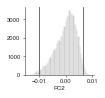

PC2 KEGG_2019_Human GENE_AND_DISTAL_10kb
Index(['Complement and coagulation cascades',
       'Fc gamma R-mediated phagocytosis', 'Measles', 'Protein export',
       'Staphylococcus aureus infection', 'T cell receptor signaling pathway'],
      dtype='object', name='description')


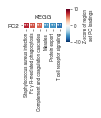

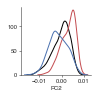

PC2 GO_Biological_Process_2018 GENE_AND_DISTAL_10kb
Index(['T cell activation (GO:0042110)',
       'T cell receptor signaling pathway (GO:0050852)',
       'antigen receptor-mediated signaling pathway (GO:0050851)',
       'neutrophil activation involved in immune response (GO:0002283)',
       'neutrophil degranulation (GO:0043312)',
       'neutrophil mediated immunity (GO:0002446)'],
      dtype='object', name='description')


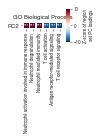

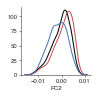

In [3]:
libraries = [misc.KEGG, misc.GO_BIO_PROCESS]
region_filters = [misc.GENE_AND_DISTAL_10kb]

pca_df = pd.read_csv(os.path.join(misc.ML_RESULTS_ROOT, 'PCA_loadings.csv.gz'), index_col=0)
pca_enr_fn = os.path.join(misc.ML_RESULTS_ROOT, 'PCA_loadings_enrichment.csv.gz')
if os.path.exists(pca_enr_fn):
    all_pthw_df = pd.read_csv(pca_enr_fn, index_col=[0, 1, 2])
else:
    all_pthw_df = utils.page(pca_df, ['{}_min15_max500_regions.{}.gmt'.format(l, r) \
                                            for l in libraries \
                                            for r in region_filters],
                             gs_path=os.path.join(misc.METADATA, 'gene_set_libraries'))
    all_pthw_df.to_csv(pca_enr_fn)
    
SHOW_N = 3
for pc in pca_df.index[[1]]:
    print(pc)
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    sns.distplot(pca_df.loc[pc], kde=False, color=GRAY)
    plt.axvline(pca_df.loc[pc].sort_values().iloc[TOP_N], c=BLUE)
    plt.axvline(pca_df.loc[pc].sort_values().iloc[-TOP_N], c=RED)
    sns.despine()
    plt.show()
    
    for library in libraries:
        for region_filter in region_filters:
            print(pc, library, region_filter)
            pthw_df = all_pthw_df.loc[(all_pthw_df.index.get_level_values('gene_set_library') == '{}_min15_max500_regions.{}.gmt'.format(library, region_filter))
                                      & (all_pthw_df.index.get_level_values('comparison') == pc)]
            pthw_df.index = pthw_df.index.get_level_values('description')
            pthw_df = pthw_df.sort_values('z_score', ascending=False)
            
            enr_df = pthw_df[['z_score', 'p_value', 'adjusted_p_value']].rename(dict(z_score='Odds Ratio', p_value='P-value', adjusted_p_value='Adjusted P-value'), axis=1)
            enr_df['Odds Ratio'] = enr_df['Odds Ratio'].abs()
            enr_df = {1: {pc: enr_df.loc[pthw_df.iloc[:SHOW_N].index]}, -1: {pc: enr_df.loc[pthw_df.iloc[-SHOW_N:].index]}}
            terms = pthw_df.iloc[:SHOW_N].index.union(pthw_df.iloc[-SHOW_N:].index)
            print(terms)

            cbar_label = 'Z-score of region\nset PC loadings'
            ax, results, _ = misc.enr_heatmap(
                celltype=None, model=None, contrasts=[pc],
                method=None, library=library, top_n=None, region_filter=region_filter,
                pthw_fdr_or_top_n=None,
                display_metric='oddsratio',
                enr_df=enr_df, terms=terms,
                pval_asterisks=PVAL_ASTERISKS,
                sort_by_n_column=-1,
                cbar_label=cbar_label,
                sort_ascending=False,
                fmt='.0e', annot_size=SMALL_FONT, rename_pthw=True,
                transpose=TRANSPOSE_ENR_TABLE, fig_width=ENR_FIG_WIDTH, cell_height=ENR_CELL_HEIGHT,
                heatmap_kws=dict(vmax=10, vmin=-10, lw=0.5),
                cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'),
                save_fig=False, show_fig=False, fig_format='svg')

            ax.tick_params(axis='x', labelsize=SMALL_FONT)
            ax.set_yticklabels([pc], rotation=0)
            ax.collections[0].colorbar.ax.set_ylabel(cbar_label.format(utils.MINUS), fontsize=SMALL_FONT)
            ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
            ax.set_title(' '.join(library.split('_201')[0].split('_')), pad=3)
            if SAVE_FIG:
                utils.savefig(os.path.join(fig_dir, 'PC_loadings.{}_{}_{}.svg'.format(pc, library, region_filter)), dpi=DPI)
            plt.show()

            fig, ax = plt.subplots(figsize=FIG_SIZE)
            sns.distplot(pca_df.loc[pc], kde=True, hist=False, color='black')
            sns.distplot(pca_df.loc[pc, eval(pthw_df.iloc[0]['genes'])], kde=True, hist=False, rug=False, color=RED)
            sns.distplot(pca_df.loc[pc, eval(pthw_df.iloc[-1]['genes'])], kde=True, hist=False, rug=False, color=BLUE)
            sns.despine()
            plt.show()

#             pc_df = pca_df.loc[[pc]].rename({pc: 'Coef'}).T.join(misc.get_peak_annot()).copy()
#             fig, axs = plt.subplots(1, 2, figsize=(FIG_SIZE[0] * 4, FIG_SIZE[1] * 2))
#             plt.subplots_adjust(wspace=2.5)
#             for ax, direction in zip(axs, [1, -1]):
#                 top_regions, enr_df = misc.gr_enrichr(
#                     pc_df, region_filter, top_n=TOP_N, coef=None, direction=direction, rank_metric='Coef',
#                     db_dir=os.path.join(misc.METADATA, 'gene_set_libraries'), gene_sets=library
#                 )
#                 if library == misc.GO_BIO_PROCESS:
#                     enr_df['Term'] = enr_df['Term'].str.replace(' \(GO:[0-9]+\)$', '')
#                 enr_df = enr_df.sort_values('P-value').iloc[:20]

#                 colors = np.asarray([LIGHT_GRAY] * enr_df.shape[0])
#                 colors[enr_df['Adjusted P-value'] < np.min(FDR)] = RED if direction > 0 else BLUE
#                 _barh = ax.barh(y=rename_pathways(enr_df['Term'][::-1]), width=-np.log10(enr_df['P-value'].values)[::-1], height=0.75, color=colors[::-1],
#                                  edgecolor='0.15', lw=0) # mpl.rcParams['lines.linewidth'] / 2
#                 ax.set_xlabel('{}log P-value'.format(misc.MINUS))
#                 ax.set_title('{}\nTop {}, {}'.format(library, TOP_N, region_filter))
#                 ax.tick_params(axis='y', which='both', labelsize=SMALL_FONT)
#                 ax.set_title('{} | {}\n{}\nFDR {}'.format('UP' if direction > 0 else 'DOWN', ' '.join(library.split('_201')[0].split('_')), region_filter, np.min(FDR)), pad=3)
#                 sns.despine()
#                 _ylim_offset = 0.6125
#                 ax.set_ylim(-_ylim_offset, enr_df.shape[0] - 1 + _ylim_offset)
#             fig.suptitle('{} enrichment'.format(pc), y=1.02)
#             if SAVE_FIG:
#                 utils.savefig(os.path.join(fig_dir, 'PCA_enrichment.{}.{}.{}.pdf'.format(pc, library, region_filter)))
#             plt.show()

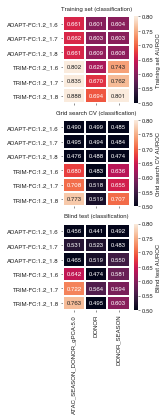

Permuted labels


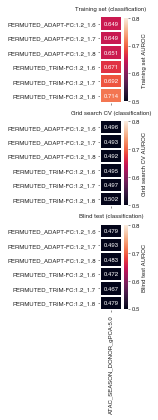

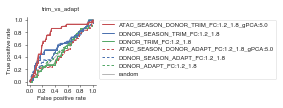

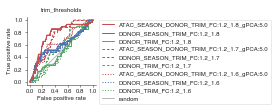

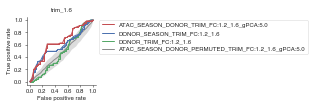

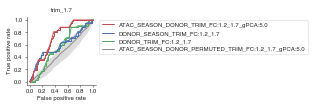

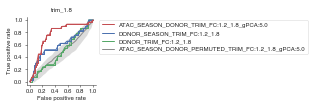

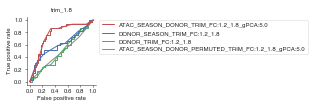

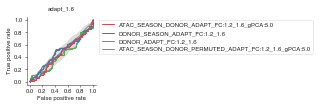

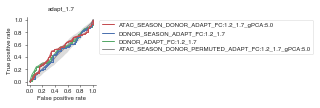

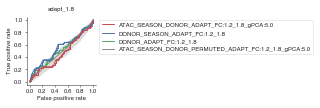

In [7]:
results_df, mean_df, _ = misc.read_ML(
#     results_fn='results/ML/BCG.ML.results.hdf',
    key='ML_final_V1_corrected_combat_groupByExactDate_thr_V1_V1_LR_L2', models=None, X_names=None,
    ys=None, X_visits=None, y_visits=None, binarizing=None, data=None, scale=True,
    show_visits=False, show_data=False, show_estimator=False,
    show_X_name=True, show_y_name=True, show_binarizing=True, rename_y={'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3': 'TRIM', 'thm.adaptive_MTB_7d_V3': 'ADAPT'})
misc.plot_ML_summary(mean_df, fontsize=FONT_SIZE, fmt='.3f')
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'ML.pdf'))
plt.show()

print('Permuted labels')
perm_results_df, perm_mean_df, _ = misc.read_ML(
#     results_fn='results/ML/BCG.ML.results.hdf',
    key='ML_final_V1_corrected_combat_groupByExactDate_thr_permuteLabels_V1_V1_LR_L2', models=None, X_names=None,
    ys=None, X_visits=None, y_visits=None, binarizing=None, data=None, scale=True,
    show_visits=False, show_data=False, show_estimator=False,
    show_X_name=True, show_y_name=True, show_binarizing=True, rename_y={'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3': 'PERMUTED_TRIM', 'thm.adaptive_MTB_7d_V3': 'PERMUTED_ADAPT'})
assert perm_results_df.index.get_level_values('model').str.contains('PERMUTED').all()
misc.plot_ML_summary(perm_mean_df, fontsize=FONT_SIZE, fmt='.3f')
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'ML_permute_labels.pdf'))
plt.show()
    
results_df = pd.concat([results_df, perm_results_df])

_dashed = (0, (2.5, 2))
smoothness = 30

TRIM_VS_ADAPT = [
    'DONOR_ADAPT_FC:1.2_1.8',
    'DONOR_SEASON_ADAPT_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.8_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.8',
    'DONOR_SEASON_TRIM_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0',
]

TRIM_THRESHOLDS = [
    'DONOR_TRIM_FC:1.2_1.6',
    'DONOR_SEASON_TRIM_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.7',
    'DONOR_SEASON_TRIM_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.8',
    'DONOR_SEASON_TRIM_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0',
]

TRIM_1_6 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.6',
    'DONOR_SEASON_TRIM_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0',
]

TRIM_1_7 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.7',
    'DONOR_SEASON_TRIM_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0',
]

TRIM_1_8 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.8',
    'DONOR_SEASON_TRIM_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0',
]

ADAPT_1_6 = [
    'ATAC_SEASON_DONOR_PERMUTED_ADAPT_FC:1.2_1.6_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.6',
    'DONOR_SEASON_ADAPT_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.6_gPCA:5.0',
]

ADAPT_1_7 = [
    'ATAC_SEASON_DONOR_PERMUTED_ADAPT_FC:1.2_1.7_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.7',
    'DONOR_SEASON_ADAPT_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.7_gPCA:5.0',
]

ADAPT_1_8 = [
    'ATAC_SEASON_DONOR_PERMUTED_ADAPT_FC:1.2_1.8_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.8',
    'DONOR_SEASON_ADAPT_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.8_gPCA:5.0',
]

TRIM_VS_ADAPT_1_6 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.6',
    'DONOR_SEASON_ADAPT_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.6_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.6',
    'DONOR_SEASON_TRIM_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0',
]

TRIM_VS_ADAPT_1_7 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.7',
    'DONOR_SEASON_ADAPT_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.7_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.7',
    'DONOR_SEASON_TRIM_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0',
]
SUPER_LIGHT_GRAY = '#e3e3e3'
for name, models, show_all_curves, colors, linestyles, show_raw, show_random, also_smoothing in [
    ('trim_vs_adapt', TRIM_VS_ADAPT, True, [GREEN, BLUE, RED, GREEN, BLUE, RED], [_dashed, _dashed, _dashed, '-', '-', '-'], True, True, False),
    ('trim_thresholds', TRIM_THRESHOLDS, True, [GREEN, BLUE, RED], [':', ':', ':', _dashed, _dashed, _dashed, '-', '-', '-'], True, True, False),
    ('trim_1.6', TRIM_1_6, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False, False),
    ('trim_1.7', TRIM_1_7, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False, False),
    ('trim_1.8', TRIM_1_8, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False, True),
    ('adapt_1.6', ADAPT_1_6, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False, False),
    ('adapt_1.7', ADAPT_1_7, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False, False),
    ('adapt_1.8', ADAPT_1_8, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False, False),
    
]:
    ax, all_y_preds, all_y_trues = misc.plot_ML_curves(
        results_df, models=models, plot_type='ROC', merge_folds=True, n_seeds=None,
        colors=colors, linestyles=linestyles, figsize=FIG_SIZE,
        title=name, show_random=show_random, random_label='random', random_color=LIGHT_GRAY, random_linestyle='-',
        show_all_curves=show_all_curves, show_mean=True, show_std=True, smoothness=smoothness, alpha_all_curves=1, alpha_std=0.3, ax=None, lw=1)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'ROC_{}.svg'.format(name)))
    plt.show()
    
    if also_smoothing:
        ax, all_y_preds, all_y_trues = misc.plot_ML_curves(
            results_df, models=models, plot_type='ROC', merge_folds=True, n_seeds=None,
            colors=colors, linestyles=linestyles, figsize=FIG_SIZE,
            title=name, show_random=show_random, random_label='random', random_color=LIGHT_GRAY, random_linestyle='-',
            show_all_curves=show_all_curves, show_mean=True, show_std=False, smoothness=10, alpha_all_curves=1, alpha_std=0.3, ax=None, lw=1)
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'ROC_{}_smooth.svg'.format(name)))
        plt.show()

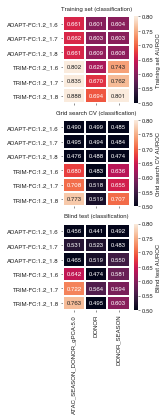

Permuted labels


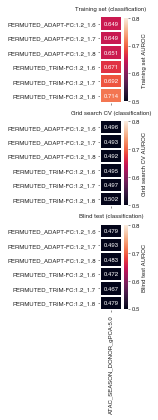

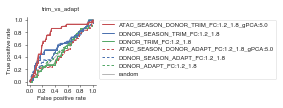

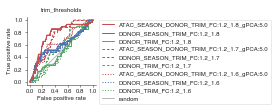

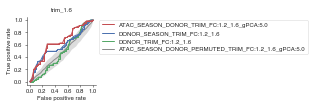

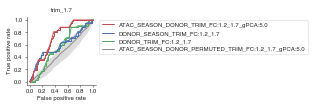

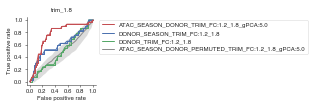

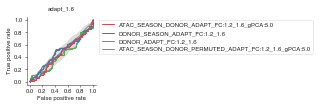

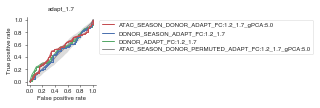

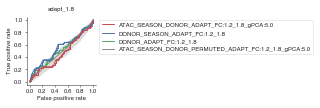

In [5]:
results_df, mean_df, _ = misc.read_ML(
#     results_fn='results/ML/BCG.ML.results.hdf',
    key='ML_final_V1_corrected_combat_groupByExactDate_thr_V1_V1_LR_L2', models=None, X_names=None,
    ys=None, X_visits=None, y_visits=None, binarizing=None, data=None, scale=True,
    show_visits=False, show_data=False, show_estimator=False,
    show_X_name=True, show_y_name=True, show_binarizing=True, rename_y={'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3': 'TRIM', 'thm.adaptive_MTB_7d_V3': 'ADAPT'})
misc.plot_ML_summary(mean_df, fontsize=FONT_SIZE, fmt='.3f')
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'ML.pdf'))
plt.show()

print('Permuted labels')
perm_results_df, perm_mean_df, _ = misc.read_ML(
#     results_fn='results/ML/BCG.ML.results.hdf',
    key='ML_final_V1_corrected_combat_groupByExactDate_thr_permuteLabels_V1_V1_LR_L2', models=None, X_names=None,
    ys=None, X_visits=None, y_visits=None, binarizing=None, data=None, scale=True,
    show_visits=False, show_data=False, show_estimator=False,
    show_X_name=True, show_y_name=True, show_binarizing=True, rename_y={'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3': 'PERMUTED_TRIM', 'thm.adaptive_MTB_7d_V3': 'PERMUTED_ADAPT'})
assert perm_results_df.index.get_level_values('model').str.contains('PERMUTED').all()
misc.plot_ML_summary(perm_mean_df, fontsize=FONT_SIZE, fmt='.3f')
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'ML_permute_labels.pdf'))
plt.show()
    
results_df = pd.concat([results_df, perm_results_df])

_dashed = (0, (2.5, 2))
smoothness = 30

TRIM_VS_ADAPT = [
    'DONOR_ADAPT_FC:1.2_1.8',
    'DONOR_SEASON_ADAPT_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.8_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.8',
    'DONOR_SEASON_TRIM_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0',
]

TRIM_THRESHOLDS = [
    'DONOR_TRIM_FC:1.2_1.6',
    'DONOR_SEASON_TRIM_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.7',
    'DONOR_SEASON_TRIM_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.8',
    'DONOR_SEASON_TRIM_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0',
]

TRIM_1_6 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.6',
    'DONOR_SEASON_TRIM_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0',
]

TRIM_1_7 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.7',
    'DONOR_SEASON_TRIM_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0',
]

TRIM_1_8 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.8',
    'DONOR_SEASON_TRIM_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0',
]

ADAPT_1_6 = [
    'ATAC_SEASON_DONOR_PERMUTED_ADAPT_FC:1.2_1.6_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.6',
    'DONOR_SEASON_ADAPT_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.6_gPCA:5.0',
]

ADAPT_1_7 = [
    'ATAC_SEASON_DONOR_PERMUTED_ADAPT_FC:1.2_1.7_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.7',
    'DONOR_SEASON_ADAPT_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.7_gPCA:5.0',
]

ADAPT_1_8 = [
    'ATAC_SEASON_DONOR_PERMUTED_ADAPT_FC:1.2_1.8_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.8',
    'DONOR_SEASON_ADAPT_FC:1.2_1.8',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.8_gPCA:5.0',
]

TRIM_VS_ADAPT_1_6 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.6',
    'DONOR_SEASON_ADAPT_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.6_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.6',
    'DONOR_SEASON_TRIM_FC:1.2_1.6',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0',
]

TRIM_VS_ADAPT_1_7 = [
    'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0',
    'DONOR_ADAPT_FC:1.2_1.7',
    'DONOR_SEASON_ADAPT_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_ADAPT_FC:1.2_1.7_gPCA:5.0',
    'DONOR_TRIM_FC:1.2_1.7',
    'DONOR_SEASON_TRIM_FC:1.2_1.7',
    'ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0',
]
SUPER_LIGHT_GRAY = '#e3e3e3'
for name, models, show_all_curves, colors, linestyles, show_raw, show_random in [
    ('trim_vs_adapt', TRIM_VS_ADAPT, True, [GREEN, BLUE, RED, GREEN, BLUE, RED], [_dashed, _dashed, _dashed, '-', '-', '-'], True, True),
    ('trim_thresholds', TRIM_THRESHOLDS, True, [GREEN, BLUE, RED], [':', ':', ':', _dashed, _dashed, _dashed, '-', '-', '-'], True, True),
    ('trim_1.6', TRIM_1_6, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False),
    ('trim_1.7', TRIM_1_7, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False),
    ('trim_1.8', TRIM_1_8, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False),
    ('adapt_1.6', ADAPT_1_6, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False),
    ('adapt_1.7', ADAPT_1_7, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False),
    ('adapt_1.8', ADAPT_1_8, [False, True, True, True], [GRAY, GREEN, BLUE, RED], ['-', '-', '-', '-'], False, False),
    
]:
    ax, all_y_preds, all_y_trues = misc.plot_ML_curves(
        results_df, models=models, plot_type='ROC', merge_folds=True, n_seeds=None,
        colors=colors, linestyles=linestyles, figsize=FIG_SIZE,
        title=name, show_random=show_random, random_label='random', random_color=LIGHT_GRAY, random_linestyle='-',
        show_all_curves=show_all_curves, show_mean=True, show_std=True, smoothness=smoothness, alpha_all_curves=1, alpha_std=0.3, ax=None, lw=1)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'ROC_{}.svg'.format(name)))
    plt.show()
    
    ax, all_y_preds, all_y_trues = misc.plot_ML_curves(
        results_df, models=models, plot_type='ROC', merge_folds=True, n_seeds=None,
        colors=colors, linestyles=linestyles, figsize=FIG_SIZE,
        title=name, show_random=show_random, random_label='random', random_color=LIGHT_GRAY, random_linestyle='-',
        show_all_curves=show_all_curves, show_mean=True, show_std=True, smoothness=100, alpha_all_curves=1, alpha_std=0.3, ax=None, lw=1)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'ROC_{}_smooth.svg'.format(name)))
    plt.show()

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. DONOR_TRIM_FC:1.2_1.6: 0.64 vs. 0.47 [0.17], p = 0.005 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. DONOR_SEASON_TRIM_FC:1.2_1.6: 0.64 vs. 0.58 [0.06], p = 0.111


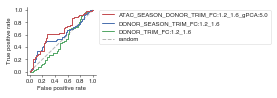

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. DONOR_TRIM_FC:1.2_1.7: 0.72 vs. 0.56 [0.16], p = 0.009 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. DONOR_SEASON_TRIM_FC:1.2_1.7: 0.72 vs. 0.59 [0.13], p = 0.011 [*]


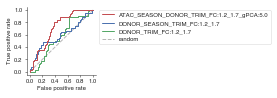

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. DONOR_TRIM_FC:1.2_1.8: 0.76 vs. 0.50 [0.27], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. DONOR_SEASON_TRIM_FC:1.2_1.8: 0.76 vs. 0.60 [0.16], p = 0.006 [**]


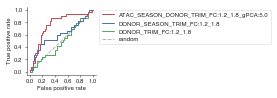

In [6]:
for thr in [1.6, 1.7, 1.8]:
    ax, all_y_preds, all_y_trues = misc.plot_ML_curves(
        results_df, models=[m.format(thr) for m in [
            'DONOR_TRIM_FC:1.2_{}', 'DONOR_SEASON_TRIM_FC:1.2_{}', 'ATAC_SEASON_DONOR_TRIM_FC:1.2_{}_gPCA:5.0']],
        plot_type='ROC', merge_folds=True, n_seeds=1, colors=[GREEN, BLUE, RED], linestyles=['-', '-', '-'], figsize=FIG_SIZE,
        title=None, show_random=True, random_label='random', random_color=LIGHT_GRAY, random_linestyle='dashed',
        show_all_curves=True, show_mean=False, show_std=False, smoothness=smoothness, alpha_all_curves=1, alpha_std=0.3, ax=None, lw=1)
    misc.calc_delongs('ATAC_SEASON_DONOR_TRIM_FC:1.2_{}_gPCA:5.0'.format(thr), all_y_trues, all_y_preds)
    plt.show()

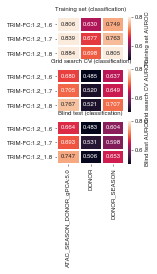

Permuted labels


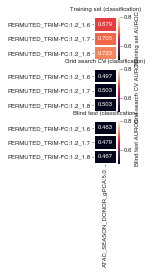

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.65 vs. 0.49 [0.16], p = 0.013 [*]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.63 vs. 0.40 [0.23], p = 0.001 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.67 vs. 0.48 [0.18], p = 0.013 [*]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.67 vs. 0.45 [0.23], p = 0.002 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.67 vs. 0.53 [0.14], p = 0.035 [*]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.70 vs. 0.51 [0.19], p = 0.009 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0: 0.68 vs. 0.40 [0.28], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 v

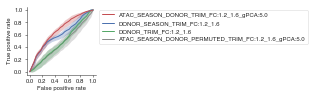

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.70 vs. 0.53 [0.18], p = 0.009 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.69 vs. 0.55 [0.15], p = 0.036 [*]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.70 vs. 0.44 [0.26], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.71 vs. 0.42 [0.29], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.70 vs. 0.66 [0.04], p = 0.532
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.71 vs. 0.57 [0.14], p = 0.061 [~]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0: 0.70 vs. 0.38 [0.32], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 vs. A

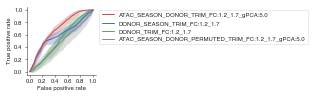

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.74 vs. 0.50 [0.24], p = 0.002 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.72 vs. 0.49 [0.23], p = 0.009 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.78 vs. 0.37 [0.40], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.76 vs. 0.36 [0.40], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.74 vs. 0.49 [0.25], p = 0.002 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.75 vs. 0.44 [0.31], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 vs. ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.8_gPCA:5.0: 0.75 vs. 0.42 [0.33], p = 0.000 [**]
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.

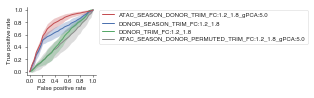

In [7]:
for subsample in [0.9]:
    results_df, mean_df, _ = misc.read_ML(
#         results_fn='results/ML/BCG.ML.results.hdf',
        key='ML_final_V1_corrected_combat_groupByExactDate_thr_subsample{}_V1_V1_LR_L2'.format(subsample),
        models=None, X_names=None,
        ys=None, X_visits=None, y_visits=None, binarizing=None, data=None, scale=True,
        show_visits=False, show_data=False, show_estimator=False,
        show_X_name=True, show_y_name=True, show_binarizing=True, rename_y={'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3': 'TRIM', 'thm.adaptive_MTB_7d_V3': 'ADAPT'})
    misc.plot_ML_summary(mean_df, fontsize=FONT_SIZE, fmt='.3f')
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, f'ML2_subsample{subsample}.pdf'))
    plt.show()
    
    print('Permuted labels')
    perm_results_df, perm_mean_df, _ = misc.read_ML(
    #     results_fn='results/ML/BCG.ML.results.hdf',
        key='ML_final_V1_corrected_combat_groupByExactDate_thr_subsample{}_permuteLabels_V1_V1_LR_L2'.format(subsample),
        models=None, X_names=None,
        ys=None, X_visits=None, y_visits=None, binarizing=None, data=None, scale=True,
        show_visits=False, show_data=False, show_estimator=False,
        show_X_name=True, show_y_name=True, show_binarizing=True, rename_y={'thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3': 'PERMUTED_TRIM', 'thm.adaptive_MTB_7d_V3': 'PERMUTED_ADAPT'})
    assert perm_results_df.index.get_level_values('model').str.contains('PERMUTED').all()
    misc.plot_ML_summary(perm_mean_df, fontsize=FONT_SIZE, fmt='.3f')
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, f'ML_subsample{subsample}_permute_labels.pdf'))
    plt.show()

    results_df = pd.concat([results_df, perm_results_df])

    for thr in [1.6, 1.7, 1.8]:
        ax, all_y_preds, all_y_trues = misc.plot_ML_curves(
            results_df, models=[m.format(thr) for m in [
                'ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_{}_gPCA:5.0',
                'DONOR_TRIM_FC:1.2_{}',
                'DONOR_SEASON_TRIM_FC:1.2_{}',
                'ATAC_SEASON_DONOR_TRIM_FC:1.2_{}_gPCA:5.0'
            ]],
            plot_type='ROC', merge_folds=True, n_seeds=None, colors=[GRAY, GREEN, BLUE, RED], linestyles=['-', '-', '-'], figsize=FIG_SIZE,
            title=None, show_random=False, random_label='random', random_color=LIGHT_GRAY, random_linestyle='dashed',
            show_all_curves=False, show_mean=True, show_std=True, show_iqr=False, show_ci=False,
            smoothness=smoothness, alpha_all_curves=1, alpha_std=0.3, all_seeds_same_data=False, ax=None, lw=1)
        misc.calc_delongs('ATAC_SEASON_DONOR_TRIM_FC:1.2_{}_gPCA:5.0'.format(thr), all_y_trues, all_y_preds)
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, 'ROC_thr{}_subsample{}.svg'.format(thr, subsample)))
        plt.show()

In [8]:
from scipy.stats import ttest_rel
full_model = 'ATAC_SEASON_DONOR_TRIM_FC:1.2_{}_gPCA:5.0'
for thr in [1.6, 1.7, 1.8]:
    df = results_df.loc[results_df.index.get_level_values('model').str.contains('FC:1.2_{}'.format(thr))].sort_index()
    s1 = df.loc[df.index.get_level_values('model') == full_model.format(thr), 'union_test_score']
    for model in set(df.index.get_level_values('model')):
        if model != full_model.format(thr):
            s2 = df.loc[df.index.get_level_values('model') == model, 'union_test_score']
            assert s1.index.get_level_values('seed').tolist() == s2.index.get_level_values('seed').tolist()
            print(full_model.format(thr), model, np.mean(s1), np.mean(s2), ttest_rel(s1, s2)[1])

ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 DONOR_SEASON_TRIM_FC:1.2_1.6 0.6644343499891845 0.6044321868916287 1.6709352282340904e-30
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.6_gPCA:5.0 0.6644343499891845 0.4632078736751028 6.21741487597039e-51
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.6_gPCA:5.0 DONOR_TRIM_FC:1.2_1.6 0.6644343499891845 0.4825567813108371 1.1025376918849077e-72
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 DONOR_TRIM_FC:1.2_1.7 0.6930296756383711 0.5311249137336094 2.234989358397178e-53
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 ATAC_SEASON_DONOR_PERMUTED_TRIM_FC:1.2_1.7_gPCA:5.0 0.6930296756383711 0.47922705314009645 1.4530230599432566e-44
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.7_gPCA:5.0 DONOR_SEASON_TRIM_FC:1.2_1.7 0.6930296756383711 0.5982953761214631 4.449829837528333e-31
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 DONOR_TRIM_FC:1.2_1.8 0.747401299350325 0.5058820589705147 9.042685352939233e-70
ATAC_SEASON_DONOR_TRIM_FC:1.2_1.8_gPCA:5.0 ATAC_S